In [1]:
import pandas as pd
import numpy as np
import validators

from datetime import datetime
from matplotlib import pyplot as plt

plt.style.use("fivethirtyeight")


In [2]:
# Data Loading

tabsv = "data/off_dataset.tsv"

df_off = pd.read_csv(tabsv, sep="\t", dtype="unicode", low_memory=False)


In [3]:
df_off.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: object(162)
memory usage: 396.5+ MB


<h2>Nettoyage du dataset</h2>

<h4>Infos du TSV</h4>
- 320772 lignes (produits)
- 162 variables (colonnes)

<h4>Sélection des variables</h4>

1 - Variables techniques :

- Un produit est défini par :
    - Son code (on ne gardera que son code EAN13, en ignorant ceux commençant par 200, préfixe utilisé par OFF par défaut)
    - Son nom (product_name)
    - Sa/ses catégories (main_category, categories)
    - Son URL
    - La data de sa derniere modification

--> Suppression des duplicatas, suppression des aberrations et incoherences


In [4]:
# Duplicates, unvalid EAN13 & OFF attributed EAN13s (200XXXXXXXXXX)
# Set of filters necessary for any study

def ean_actions(df: pd.DataFrame) -> pd.DataFrame:
    df.dropna(subset="code", inplace=True)
    df.drop_duplicates(subset="code", keep="first", inplace=True)
    df = df[~df["code"].str.startswith(('200'))]
    df = df[df["code"].map(len) == 13]
    
    return df


In [5]:
df_off = ean_actions(df=df_off)


In [6]:
# Removing non numeric values for last_modified_t
# Removing aberrations in timestamps, modifying timestamp type to float

df_off = df_off[pd.to_numeric(df_off['last_modified_t'], errors='coerce').notnull()]
now_t = datetime.timestamp(datetime.now())

df_off["last_modified_t"] = df_off["last_modified_t"].astype(float)

df_off = df_off[(df_off["last_modified_t"] < now_t) & (df_off["last_modified_t"] > 0)]


In [7]:
%%time

# Applying filters
# Category needs at least 1

condition_list = ["url", "product_name", "nutrition_grade_fr"]
category_list =  ["main_category", "categories"]

df_off.dropna(subset=condition_list, inplace=True)
df_off = df_off.dropna(subset=category_list, thresh=1).reset_index(drop=True)


CPU times: total: 688 ms
Wall time: 698 ms


In [8]:

for col in df_off.columns:
    print(col)


code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
generic_name
quantity
packaging
packaging_tags
brands
brands_tags
categories
categories_tags
categories_fr
origins
origins_tags
manufacturing_places
manufacturing_places_tags
labels
labels_tags
labels_fr
emb_codes
emb_codes_tags
first_packaging_code_geo
cities
cities_tags
purchase_places
stores
countries
countries_tags
countries_fr
ingredients_text
allergens
allergens_fr
traces
traces_tags
traces_fr
serving_size
no_nutriments
additives_n
additives
additives_tags
additives_fr
ingredients_from_palm_oil_n
ingredients_from_palm_oil
ingredients_from_palm_oil_tags
ingredients_that_may_be_from_palm_oil_n
ingredients_that_may_be_from_palm_oil
ingredients_that_may_be_from_palm_oil_tags
nutrition_grade_uk
nutrition_grade_fr
pnns_groups_1
pnns_groups_2
states
states_tags
states_fr
main_category
main_category_fr
image_url
image_small_url
energy_100g
energy-from-fat_100g
fat_100g
saturated-fat_100g
butyr

In [9]:
# pnns_group_1 & pnns_group_2 seems to be main category, and category of main category ?

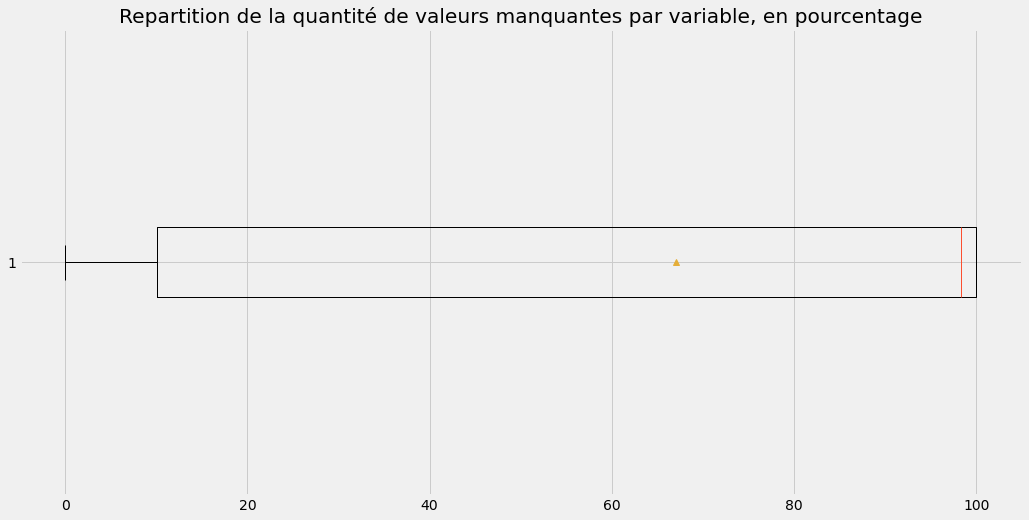

In [10]:
#NA Amount % = [NA amount / len(df)] / 100

data_len = len(df_off)
above_fifty = []
above_seventy_five = []
under_fifty = []
nan_per_col = {}

for column in df_off.columns:
    nan_percent = df_off[column].isnull().sum() / data_len * 100
    if nan_percent > 75:
        above_seventy_five.append(column)
    elif nan_percent > 50:
        above_fifty.append(column)
    else:
        under_fifty.append(column)
    nan_per_col[column] = nan_percent

box = plt.figure(figsize=(16, 8))

plt.title("Repartition de la quantité de valeurs manquantes par variable, en pourcentage")

plt.boxplot(nan_per_col.values(), vert=False, showfliers=True, showmeans=True)

plt.show()


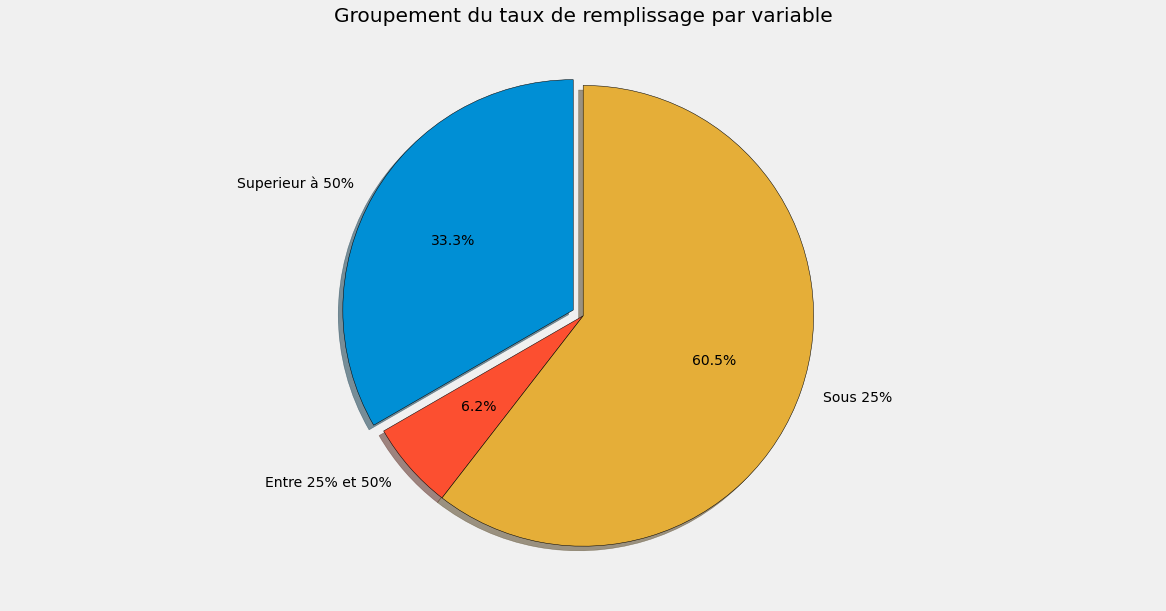

In [11]:

slices = [len(under_fifty), len(above_fifty), len(above_seventy_five)]
labels = ["Superieur à 50%", "Entre 25% et 50%", "Sous 25%"]

explode = [0.05, 0, 0]

fig = plt.figure(figsize=(16,8))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(slices, labels=labels, explode=explode, shadow=True,
        startangle=90, autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'})


plt.title("Groupement du taux de remplissage par variable")

plt.show()


Seulement 33.3% des colonnes présentent un taux de remplissage au dessus de 50%, après avoir appliqué les filtres des étapes précédentes.
Il est possible que la plupart des valeurs manquantes viennent des valeurs pour 100g.

Verification en ajustant les parametres pour exclure les valeurs pour 100g.

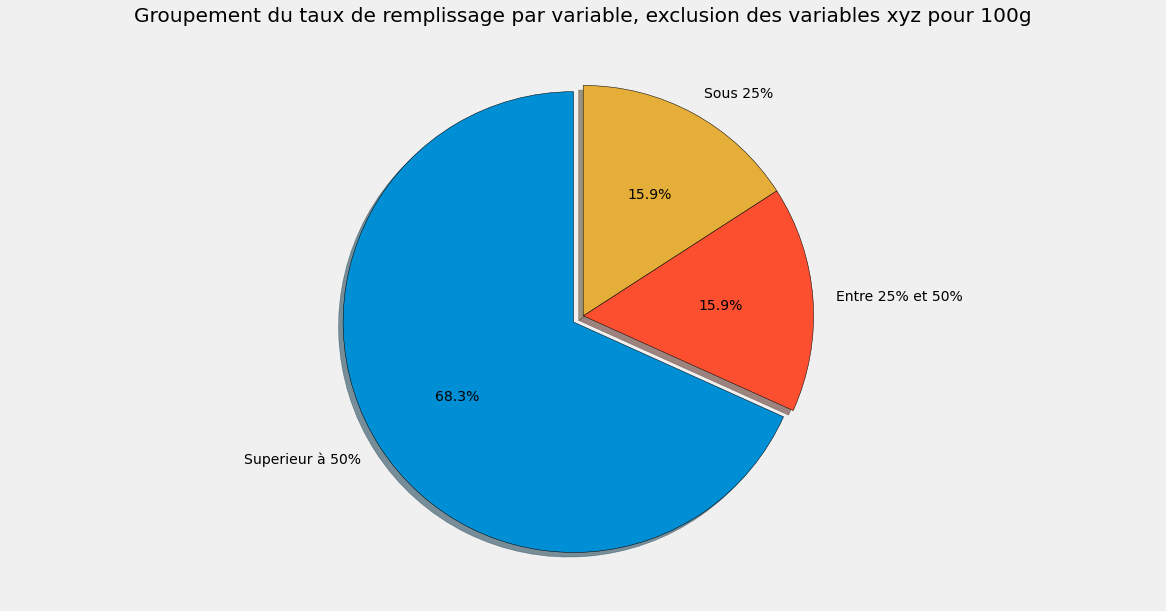

In [12]:

above_fifty = []
above_seventy_five = []
under_fifty = []
nan_per_col = {}

for column in df_off.columns:

    if column.endswith("100g"): #  Skipping names ending with 100g
        continue

    nan_percent = df_off[column].isnull().sum() / data_len * 100

    if nan_percent > 75:
        above_seventy_five.append(column)

    elif nan_percent > 50:
        above_fifty.append(column)

    else:
        under_fifty.append(column)
    nan_per_col[column] = nan_percent


slices = [len(under_fifty), len(above_fifty), len(above_seventy_five)]
labels = ["Superieur à 50%", "Entre 25% et 50%", "Sous 25%"]

explode = [0.05, 0, 0]

fig = plt.figure(figsize=(16,8))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(slices, labels=labels, explode=explode, shadow=True,
        startangle=90, autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'})


plt.title("Groupement du taux de remplissage par variable, exclusion des variables xyz pour 100g")

plt.show()


Les valeurs pour 100g affectent effectivement négativement le taux de variables manquantes. Une de ces raisons est sans doute le fait que certains composants ne figurent simplement pas dans le produit.

Une sélection plus en détail des composants principaux pour refléter les besoins de l'application sera faite.
Un premier filtrage des aberration va etre fait pour determiner si certains produits ont des valeurs aberrantes dans ces categories, si c'est le cas, le produit sera supprimé du dataset, les autres données sont plus suceptibles d'etre elles aussi fausses.

Les variables avec un taux de remplissage inferieur à 50% (excluant les valeurs pour 100g) seront abandonnées, à l'exception de possibles variables necessaires au fonctionnement de l'application.

In [13]:
for col in under_fifty:
    print(col)


code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
generic_name
quantity
packaging
packaging_tags
brands
brands_tags
categories
categories_tags
categories_fr
labels
labels_tags
labels_fr
purchase_places
stores
countries
countries_tags
countries_fr
ingredients_text
serving_size
additives_n
additives
additives_tags
additives_fr
ingredients_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_n
nutrition_grade_fr
pnns_groups_1
pnns_groups_2
states
states_tags
states_fr
main_category
main_category_fr
image_url
image_small_url


In [14]:
# Var selection

useless_vars = [
    "states_tags", "ingredients_text", "states_tags", "creator",
    "states_fr", "main_category", "serving_size", "created_datetime",
    "additives", "additives_fr", "main_category", "ingredients_text",
    "last_modified_datetime", "quantity", "countries", "countries_fr",
    "created_t",
]
maybe_useless = ["packaging", "packaging_tags", "image_small_url", "generic_name", "brands_tags", "purchase_places"]

useful_above_fifty = ["allergens"]
df_off["labels_fr"]

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                                                      NaN
4        Agriculture durable,UTZ Certified,UTZ Certifie...
                               ...                        
52191                                   Sans conservateurs
52192                                                  NaN
52193               Point Vert,Pur jus,Riche en vitamine C
52194                                                  NaN
52195    Bio,Bio européen,Sans gluten,AB Agriculture Bi...
Name: labels_fr, Length: 52196, dtype: object

<h4>Variables techniques necessaires :</h4>

- code
- url
- last_modified_t
- product_name
- categories_fr


<h4>Variables metier interessantes :</h4>

- pnns_groups_1 & 2
- categories + categories_tags (?) (choix en fonction du taux de remplissage s'il diffère)
- main_category_fr
- nutrition_grade_fr
- image_url ?
- brands
- stores
- countries_fr
- ingredients_from_palm_oil_n
- ingredients_that_may_be_from_palm_oil_n
- labels (?) -> Sera choisi en fonction du taux de remplissage (labels, labels_tags, labels_fr)
- allergens (variable peu remplie mais importante à l'application : le manque de donnée peut signifier l'absence d'allergène ou le manque d'information)



In [15]:
remaining = list(set(under_fifty) - set(useless_vars) - set(maybe_useless))
remaining = remaining + useful_above_fifty
remaining.sort()
for col in remaining:
    print(col)
print("\n", len(remaining))


additives_n
additives_tags
allergens
brands
categories
categories_fr
categories_tags
code
countries_tags
image_url
ingredients_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_n
labels
labels_fr
labels_tags
last_modified_t
main_category_fr
nutrition_grade_fr
pnns_groups_1
pnns_groups_2
product_name
states
stores
url

 24


In [16]:
def get_green_rating(series: pd.Series):
    green_dict = {
        "palm_oil": 0,
        "bio": 0,
        "conservators": 0
    }
    pass
    

In [21]:
df_off["labels"]

28318

Exploration de la coherence/pertinence des valeurs pour 100g ;
Recuperation des donnees pertienentes, elimination des autres.


In [19]:
hundred_g_list = [col for col in df_off.columns if col.endswith("100g")]
print(len(hundred_g_list))


99
